# Demography of duplicate genes

Arthur Zwaenepoel - August 2018

Assume a population of $N$ genes, residing happily in a genome. The genes duplicate at rate $\lambda$ (birth) and get lost at rate $\mu$ (death), but never such that $N < N_0$, assuming the organism needs at least a particular set of $N_0$ genes to be viable (this is the initial set of genes). We further assume that neo- or subfunctionalization leads to fixation of duplicate genes at rate $\phi$. Although this last assumption is not necessary to show the basic effects of continuous birth and death of duplicates through small-scale duplication events, it contributes some additional biological realism. Note that more sophisticated simulation studies can be found in Vanneste *et al.* (2013), where a similar model was combined with explicit simulation of synonymous sequence evolution and whole genome duplications.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
%matplotlib inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def duplication_loss_simulation(N0=1000, lm=0.1, mu=0.1, t=1, ph=0.0):
    """
    Simulate the demography of duplicate genes, assuming constant birth & death rate 
    as well as a base number of genes. A rate of fixation of duplicates can also be
    specified.

    :param N0: number of base (initial, immortal) genes
    :param lm: birth (duplication) rate
    :param mu: death (loss) rate
    :param t: evolutionary time
    :param ph: fixation rate of duplicates
    :return: (duplicates, base population size, total population size) 
    """
    N = N0  # start with N0 genes
    population = []  # this stores all non-essential duplicates in the population and their age
    fixed = []  # this stores all fixed duplicates and their age
    rates = ph + mu + lm  # this is the total rate of an event happening (duplication, loss, fixation)

    # the waiting time until the first event is an exponentially distributed
    # variable with rate the sum of the rates x the number of genes
    waiting_time = rnd.expovariate((rates)*N)
    t -= waiting_time
    
    # loop until the desired time has passed
    while t > 0:    
        r = rnd.random()
        
        # fixation, inccrements N0 and moves a gene from population to fixed
        if r < ph/(rates) and N>N0:
            fixed_gene = population.pop(rnd.randrange(len(population)))
            fixed.append(fixed_gene)
            N0 += 1
            
        # duplication
        elif r < (lm+ph)/(rates):
            population.append(0.0)
            N += 1
            
        # loss 
        elif N > N0:
            population.pop(rnd.randrange(len(population)))
            N -= 1
            
        # increment age of all duplicates in the population
        for i in range(len(population)):
            population[i] += waiting_time
            
        # increment age of all fixed duplicates
        for i in range(len(fixed)):
            fixed[i] += waiting_time
            
        # draw next waiting time
        waiting_time = rnd.expovariate((rates)*N)
        t -= waiting_time
    
    return population + fixed, N, N0

In [80]:
lm, mu, ph = 0.3, 0.25, 0.02
pop, N, N0 = duplication_loss_simulation(N0=20000, lm=lm, mu=mu, ph=ph, t=1)
N0, N, len(pop)

(20405, 21059, 1059)

/home/arzwa/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


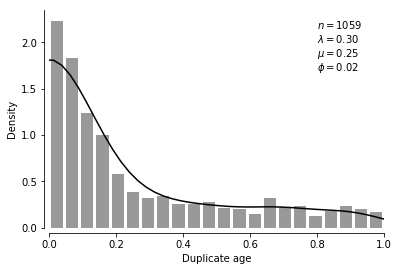

In [81]:
fig, ax = plt.subplots()

# perform KDE on the reflected data to avoid boundary effects
sns.distplot(pop + [-1*x for x in pop], hist_kws={'rwidth':0.8}, color="k")

# plot aesthetics
ax.set_xlim(0, max(pop))
ax.set_xlabel("Duplicate age")
ax.set_ylabel("Density")
ax.text(s="$n = {}$".format(len(pop)), x=0.8, y=ax.get_ylim()[1]-0.2)
ax.text(s="$\lambda = {:.2f}$".format(lm), x=0.8, y=ax.get_ylim()[1]-0.35)
ax.text(s="$\mu = {:.2f}$".format(mu), x=0.8, y=ax.get_ylim()[1]-0.5)
ax.text(s="$\phi = {:.2f}$".format(ph), x=0.8, y=ax.get_ylim()[1]-0.65)
sns.despine(offset=5)

fig.savefig("ssd_simulation.pdf")

In [28]:
lm, mu, ph = 0.03, 0.031, 0.005
pop, N, N0 = duplication_loss_simulation(N0=20000, lm=lm, mu=mu, ph=ph, t=30)
N0, N, len(pop)

(22784, 22792, 2792)

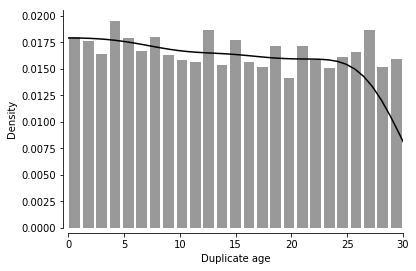

In [29]:
fig, ax = plt.subplots()

# perform KDE on the reflected data to avoid boundary effects
sns.distplot(pop + [-1*x for x in pop], bins=50, hist_kws={'rwidth':0.8}, color="k")

# plot aesthetics
ax.set_xlim(0, max(pop))
ax.set_xlabel("Duplicate age")
ax.set_ylabel("Density")

sns.despine(offset=5)